## 0.Librerías

In [1]:
import os
import pandas as pd
import time

import numpy as np
from tqdm import tqdm
#from skimage.io import imread, imshow
#from skimage.transform import resize
import matplotlib.pyplot as plt
import datetime
import cv2
#Metricas
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report,ConfusionMatrixDisplay
%env SM_FRAMEWORK=tf.keras
# Librerias para constuir la arquitectura U-Net
from tensorflow.keras.layers import Input, Lambda, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate, MaxPool2D
from tensorflow.keras.models import Model
#import segmentation_models as sm
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf

env: SM_FRAMEWORK=tf.keras


In [2]:
from google.colab import drive
drive.mount('/content/drive')
# Cambia el directorio de trabajo a la carpeta deseada
os.chdir('/content/drive/MyDrive')
os.listdir()

Mounted at /content/drive


['Colab Notebooks',
 'buildings_png',
 'build_models',
 'roads_png',
 'road_models',
 'road_build_models',
 'build_models_custom',
 'Multiclass_img',
 'model_structure.png']

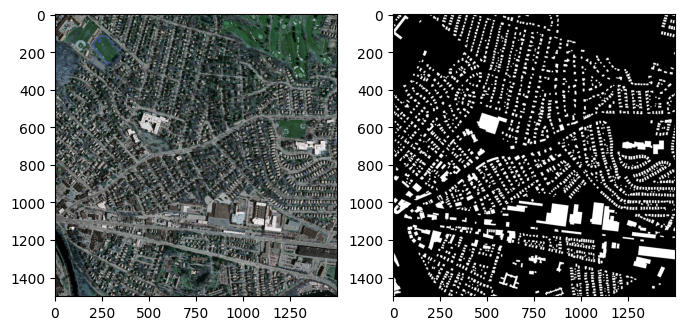

In [3]:
# Mostramos la imagen y su mascara asociada
m=18
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
img=cv2.imread('buildings_png/train/22679020_15.png')[:,:,:3]
plt.imshow(img)
plt.subplot(1,2,2)
img=cv2.imread('buildings_png/train_labels/22679020_15.png')[:,:,:3]
plt.imshow(img, cmap='gray')
plt.show()

# 1.Preprocesado Con cortes

Como las imagenes son muy grandes (1500x1500) hay dos opciones, podemos reducir su tamaño perdiendo resolucion y calidad de imagen pero manteniendo la info espacial o realizar cortes de tamaño deseado manteniendo así la resolucion en pro de perder esa info espacial por corte. Debido al tamaño pequeño de las construcciones, creo que es más importante tener más resolución.

In [4]:
def obtener_corte(img,cut=224,tipo='img'):
    """
    FUNCION:    Obtener cortes de una imagen dada de un tamaño (cutxcut)

    PARAMS:
        img: np.array de la imagen por cv2.imread()
        cut: tamaño del corte
        type: indica si es una imagen o su mascara (msk)

    RETURN:
        array_tot: np.array(numero_cortes,cut,cut,canales) donde canales son 3 en las imagenes
        normales y nada en las mascaras

    """
    # Obtener las dimensiones de la imagen (alto, ancho, canales)
    if tipo == 'img':
        alto, ancho, _ = img.shape
        formato=(1,cut,cut,3)
    elif tipo == 'msk':
        alto, ancho= img.shape
        formato=(1,cut,cut)

    # Definir las coordenadas para el recorte
    max_val_recorte=alto-cut
    max_val_recorte_x=ancho-cut
    array_tot=np.array([])
    #bucle ene le eje X
    for j in range(1,int(ancho/cut)+2):
        if cut*j<ancho:
            corte_ini_x=cut*(j-1)
            corte_fin_x=cut*j
        else:
            corte_ini_x=max_val_recorte_x
            corte_fin_x=ancho
        #Bucle en el eje Y
        for i in range(1,int(alto/cut)+2):
            if cut*i<alto:
                corte_ini=cut*(i-1)
                corte_fin=cut*i
            else:
                corte_ini=max_val_recorte
                corte_fin=alto
            # Realizar el recorte de la imagen
            if tipo == 'img':
                trozo_imagen = img[corte_ini:corte_fin, corte_ini_x:corte_fin_x,:]
            elif tipo == 'msk':
                trozo_imagen = img[corte_ini:corte_fin, corte_ini_x:corte_fin_x]
            #agrupar imagenes en un mismo array
            if array_tot.shape[0]>0:
                array_tot=np.vstack([array_tot,trozo_imagen.reshape(formato)])
            else:
                array_tot=trozo_imagen.reshape(formato)
    return array_tot
def num_percentage(img,num=0):
    """
    FUNCION: Devuelve el factor existente entre pixeles de un numero concreto y los pixeles totales de la imagen

    PARAMS:
        img: np.array de la imagen por cv2.imread()

    RETURN:
        num_factor= float pixeles del numero num/ pixeles totales

    """
    total_pixels = img.shape[0] * img.shape[1]
    num_pixels = np.sum(img == num)  # Contar píxeles blancos
    num_factor=num_pixels / total_pixels
    return num_factor
def filter_cut_images(data_path_images, data_path_masks,cut=224,positive_min_mask=0.001,limite=0):
    """
    FUNCION: Dados los directorios donde se encuentran imagenes y mascaras, obtener los recortes de cada una de ellas

    PARAMS:
        data_path_images,data_path_masks: path de imagenes y mascaras
        cut: tamaño del corte
        positive_min_mask: indica el factor minimo de puntos blancos/valores positivos en una mascara. Esto es ideal
            para filtrar imagenes con mucho fondo (valores negativos) vs información (mascara/valores positvos)
        limite: limita el numero de imagenes que se van a procesar. Ideal por si tenemos demasiadas
    RETURN:
        white_factor= float pixeles blancos/ pixeles totales
        final_images: np.array(num,cut,cut,3) array con los resultados de los cortes para las imagenes
        final_masks: np.array(num,cut,cut) array con los resultados de los cortes para las mascaras
    """

    data_list_images = os.listdir(data_path_images)
    final_images = []
    final_masks = []
    num_img_discard=0
    mask_factors=[]

    limite = len(data_list_images) if limite == 0 else limite

    for file_name in tqdm(data_list_images[:limite]):
        # Leer la imagen
        img = cv2.imread(os.path.join(data_path_images, file_name))[:,:,:3]
        mask_file = os.path.splitext(file_name)[0] + '.png'  # Nombre de la máscara
        mask_path = os.path.join(data_path_masks, mask_file)
        if os.path.exists(mask_path):
            # Leer mascara
            mask = cv2.imread(mask_path)[:,:,1]
            mask_factor=num_percentage(mask,255)
            if mask_factor>positive_min_mask:
                mask_factors.append(mask_factor)
                # Obtener cortes
                img_trozos_imagen=obtener_corte(img,cut,tipo='img')
                #agregar a lista
                img_trozos_list=[trozo for trozo in img_trozos_imagen]
                final_images+=img_trozos_list
                #obtener cortes de la mascara
                mask_trozos_imagen=obtener_corte(mask,cut,tipo='msk')
                #agregar a lista
                mask_trozos_list=[trozo for trozo in mask_trozos_imagen]
                final_masks+=mask_trozos_list
            else:
                num_img_discard+=1
        else:
            num_img_discard+=1
    print(f'Se han descartado {num_img_discard} imagenes')
    # Convertir las listas en arrays NumPy
    final_images = np.asarray(final_images, dtype=np.uint8)
    final_masks = np.asarray(final_masks, dtype=np.uint8)
    #Pasamos valores de 255 a 1
    final_masks[final_masks==255]=1
    mask_factors =np.array(mask_factors)

    return final_images, final_masks, mask_factors

In [5]:
# Definir las dimensiones de las imágenes
cut=224
white_threshold = 0.1

# Directorios de los conjuntos de datos
data_path_train = "buildings_png/train"
data_path_train_mask = "buildings_png/train_labels"
data_path_test = "buildings_png/test"
data_path_test_mask = "buildings_png/test_labels"
data_path_val = "buildings_png/val"
data_path_val_mask = "buildings_png/val_labels"

X_train_pro, Y_train_pro, mask_factors_train = filter_cut_images(data_path_train, data_path_train_mask, cut=cut,limite=0)
print('X_train:', X_train_pro.shape)
print('Y_train:', Y_train_pro.shape)

X_test_pro, Y_test_pro, mask_factors_test = filter_cut_images(data_path_test, data_path_test_mask, cut=cut,limite=0)
print('X_test:', X_test_pro.shape)
print('Y_test:', Y_test_pro.shape)

X_val_pro, Y_val_pro, mask_factors_val = filter_cut_images(data_path_val, data_path_val_mask, cut=cut,limite=0)
print('X_val:', X_val_pro.shape)
print('Y_val:', Y_val_pro.shape)

100%|██████████| 107/107 [02:09<00:00,  1.21s/it]


Se han descartado 0 imagenes
X_train: (5243, 224, 224, 3)
Y_train: (5243, 224, 224)


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


Se han descartado 0 imagenes
X_test: (490, 224, 224, 3)
Y_test: (490, 224, 224)


100%|██████████| 4/4 [00:07<00:00,  1.82s/it]

Se han descartado 0 imagenes
X_val: (196, 224, 224, 3)
Y_val: (196, 224, 224)


**Nota**: el dataset esta desbalanceado, es decir, el numero de valores positivos (estructuras) detectados en la mascara vs numero de valores negativos no es 50/50. Esto es importante a la hora de evaluar la calidad de los resultados

In [6]:

df_dat=pd.DataFrame({
    'Train':[mask_factors_train.max(),mask_factors_train.mean(),mask_factors_train.min()],
    'Test':[mask_factors_test.max(),mask_factors_test.mean(),mask_factors_test.min()],
    'Val':[mask_factors_val.max(),mask_factors_val.mean(),mask_factors_val.min()],
},index=['Max','Mean','Min'])
print('Factores asociados a Valores positivos/ Total valores')
display(df_dat)
time.sleep(0.1)
print('Precisiones esperadas en función de los valores positivos')
display(1-df_dat)

Factores asociados a Valores positivos/ Total valores


,Train,Test,Val
Max,0.306144,0.356886,0.150586
Mean,0.137243,0.186066,0.108843
Min,0.033270,0.088069,0.059696


Precisiones esperadas en función de los valores positivos


,Train,Test,Val
Max,0.693856,0.643114,0.849414
Mean,0.862757,0.813934,0.891157
Min,0.966730,0.911931,0.940304


Por ejemplo, en el entrenamiento, esperamos precisiones mínimas de 0.69 y en donde evolucionen a precisiones superiores al 0.86. Esto ya que al tener un 0.13 (1-0.13=0.86) de media de pixeles blancos un modelo que pusiese todos los valores a 0, obtendría esta precision de 0.86

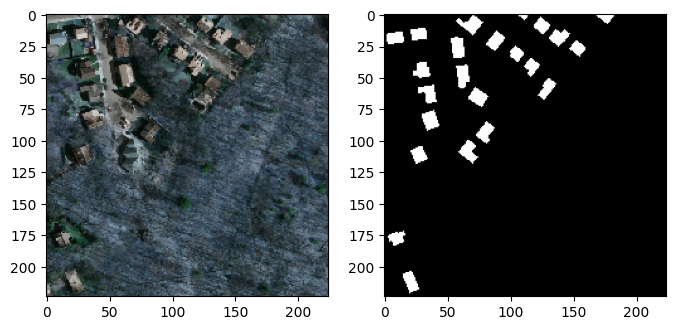

In [7]:
# Mostramos la imagen y su mascara asociada
m=18
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(X_val_pro[m])
plt.subplot(1,2,2)
plt.imshow(Y_val_pro[m], cmap='gray')
plt.show()

# 2.Entrenamiento

**Desarrollo de la la red U-NET**       
Encoder blocks ---> bottleneck ---> Decoder blocks

In [7]:
def double_conv_block(x, n_filters):

   # 2* Conv2D, ReLU activation
   x = Conv2D(n_filters, 3, padding = "same", activation = "relu")(x)#, kernel_initializer = "glorot_normal"
   x = Conv2D(n_filters, 3, padding = "same", activation = "relu")(x)

   return x
def encoder_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = MaxPool2D(pool_size =(2,2))(f)
   p = Dropout(0.1)(p)

   return f, p
def decoder_block(x, conv_features, n_filters):
   # upsample/decoder
   x = Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   x = concatenate([x, conv_features])#concatenate with enconder
   x = Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)

   return x
def custom_Unet(shape=(224,224,3),classes=1,activation='sigmoid'):
   # inputs
   inputs = Input(shape=shape)

   # encoder: contracting path - downsample
   # 1 
   f1, p1 = encoder_block(inputs, 32)
   # 2 
   f2, p2 = encoder_block(p1, 64)
   # 3 
   f3, p3 = encoder_block(p2, 128)
   # 4 
   f4, p4 = encoder_block(p3, 256)

   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 512)

   # decoder: expanding path - upsample
   # 6
   u6 = decoder_block(bottleneck, f4, 256)
   # 7 
   u7 = decoder_block(u6, f3, 128)
   # 8 
   u8 = decoder_block(u7, f2, 64)
   # 9 
   u9 = decoder_block(u8, f1, 32)

   # outputs
   outputs = Conv2D(classes, 1, padding="same", activation = activation)(u9)

   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

   return unet_model

In [8]:
unet_model=custom_Unet(shape=(224,224,3),classes=1,activation='sigmoid')
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
unet_model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 224, 224, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 224, 224, 32)   │          9,248 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 112, 112, 32)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 112, 112, 32)   │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 112, 112, 64)   │         18,496 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 112, 112, 64)   │         36,928 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 56, 56, 64)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 56, 56, 64)     │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 56, 56, 128)    │         73,856 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 56, 56, 128)    │        147,584 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 28, 28, 128)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 28, 28, 128)    │              0 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 28, 28, 256)    │        295,168 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 28, 28, 256)    │        590,080 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 14, 14, 256)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 14, 14, 256)    │              0 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)    

 Total params: 8,630,497 (32.92 MB)

 Trainable params: 8,630,497 (32.92 MB)

 Non-trainable params: 0 (0.00 B)

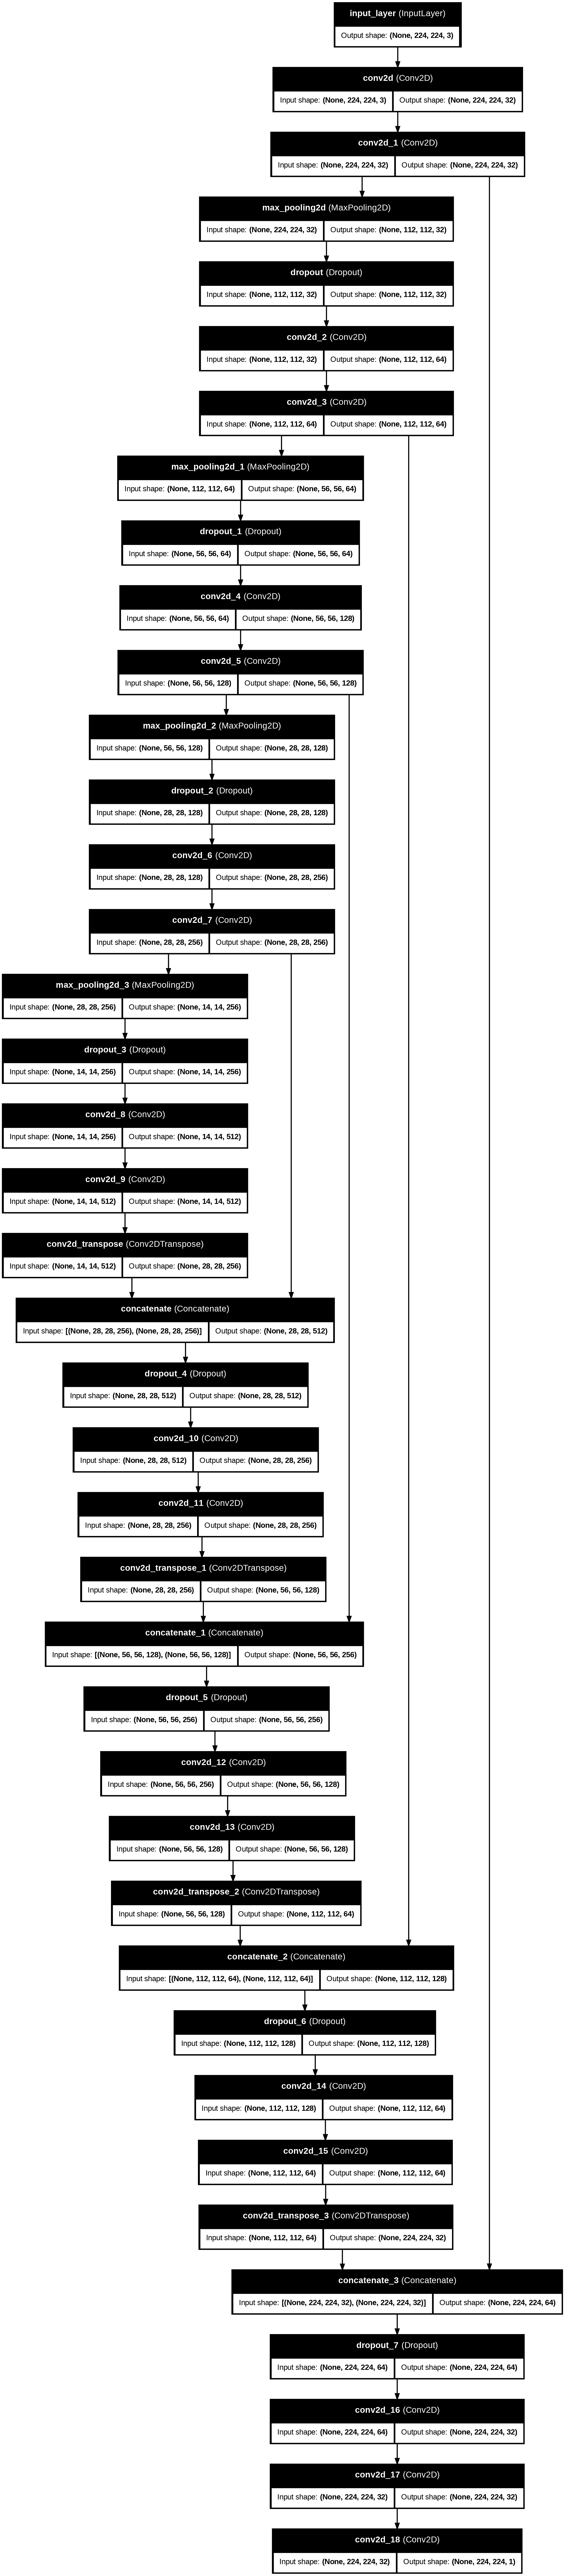

In [11]:
from tensorflow.keras.utils import plot_model

plot_model(unet_model, to_file='model_structure.png', show_shapes=True, show_layer_names=True)


In [9]:
checkpoint = ModelCheckpoint(filepath='build_models_custom/modelo-{epoch:02d}-{val_accuracy:.2f}.weights.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             save_weights_only=True, 
                             mode='max',  # 'max' para 'accuracy'
                             verbose=1)

**Nota:** Debido al alto coste computacional este comando se ha ejecutado desde la GPU de Google Collab, como se ve, ha tardado unos 41min para solo 20 epocas.

In [10]:
start=time.time()
history=unet_model.fit(
   x=X_train_pro[:],
   y=Y_train_pro[:].astype(np.float16),
   batch_size=16,
   epochs=20,
   validation_data=(X_test_pro, Y_test_pro.astype(np.float16)),
   callbacks=[checkpoint],
)
print(f'Finalizado en {round(time.time()-start,2)} s')

Epoch 1/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.8362 - loss: 0.6560
Epoch 1: val_accuracy improved from -inf to 0.86462, saving model to build_models_custom/modelo-01-0.86.weights.h5
328/328 ━━━━━━━━━━━━━━━━━━━━ 161s 383ms/step - accuracy: 0.8363 - loss: 0.6551 - val_accuracy: 0.8646 - val_loss: 0.3074
Epoch 2/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.9055 - loss: 0.2306
Epoch 2: val_accuracy improved from 0.86462 to 0.88446, saving model to build_models_custom/modelo-02-0.88.weights.h5
328/328 ━━━━━━━━━━━━━━━━━━━━ 132s 264ms/step - accuracy: 0.9055 - loss: 0.2306 - val_accuracy: 0.8845 - val_loss: 0.2726
Epoch 3/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.9202 - loss: 0.1935
Epoch 3: val_accuracy improved from 0.88446 to 0.90746, saving model to build_models_custom/modelo-03-0.91.weights.h5
328/328 ━━━━━━━━━━━━━━━━━━━━ 141s 261ms/step - accuracy: 0.9202 - loss: 0.1935 - val_accuracy: 0.9075 - val_loss: 0.2268
Epoch 4/20
328/328 ━━━

In [11]:
unet_model.save_weights('build_models_custom/model_final.weights.h5')

In [13]:
import json

# Guardar el history en un archivo JSON
with open('history.json', 'w') as f:
    json.dump(history.history, f)

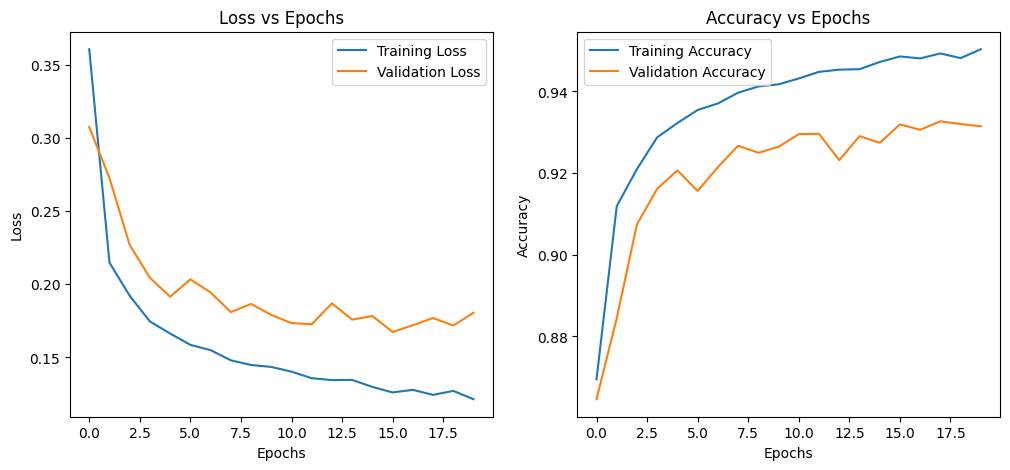

In [12]:
# Obtener los datos de 'loss' y 'accuracy' del objeto history
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history.get('accuracy')  # 'accuracy' es la métrica de precisión
val_accuracy = history.history.get('val_accuracy')  # Precisión en validación

# Crear el gráfico de Loss vs Epochs
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Mostrar los gráficos
plt.show()

**Nota:** Apesar de las fluctuaciones en validación, la pérdida y precisiones parecen estabilizarse en epocas "altas" de 15-20. Alomejor se podría haber rascado algo más con más épocas pero tampoco mucho más

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


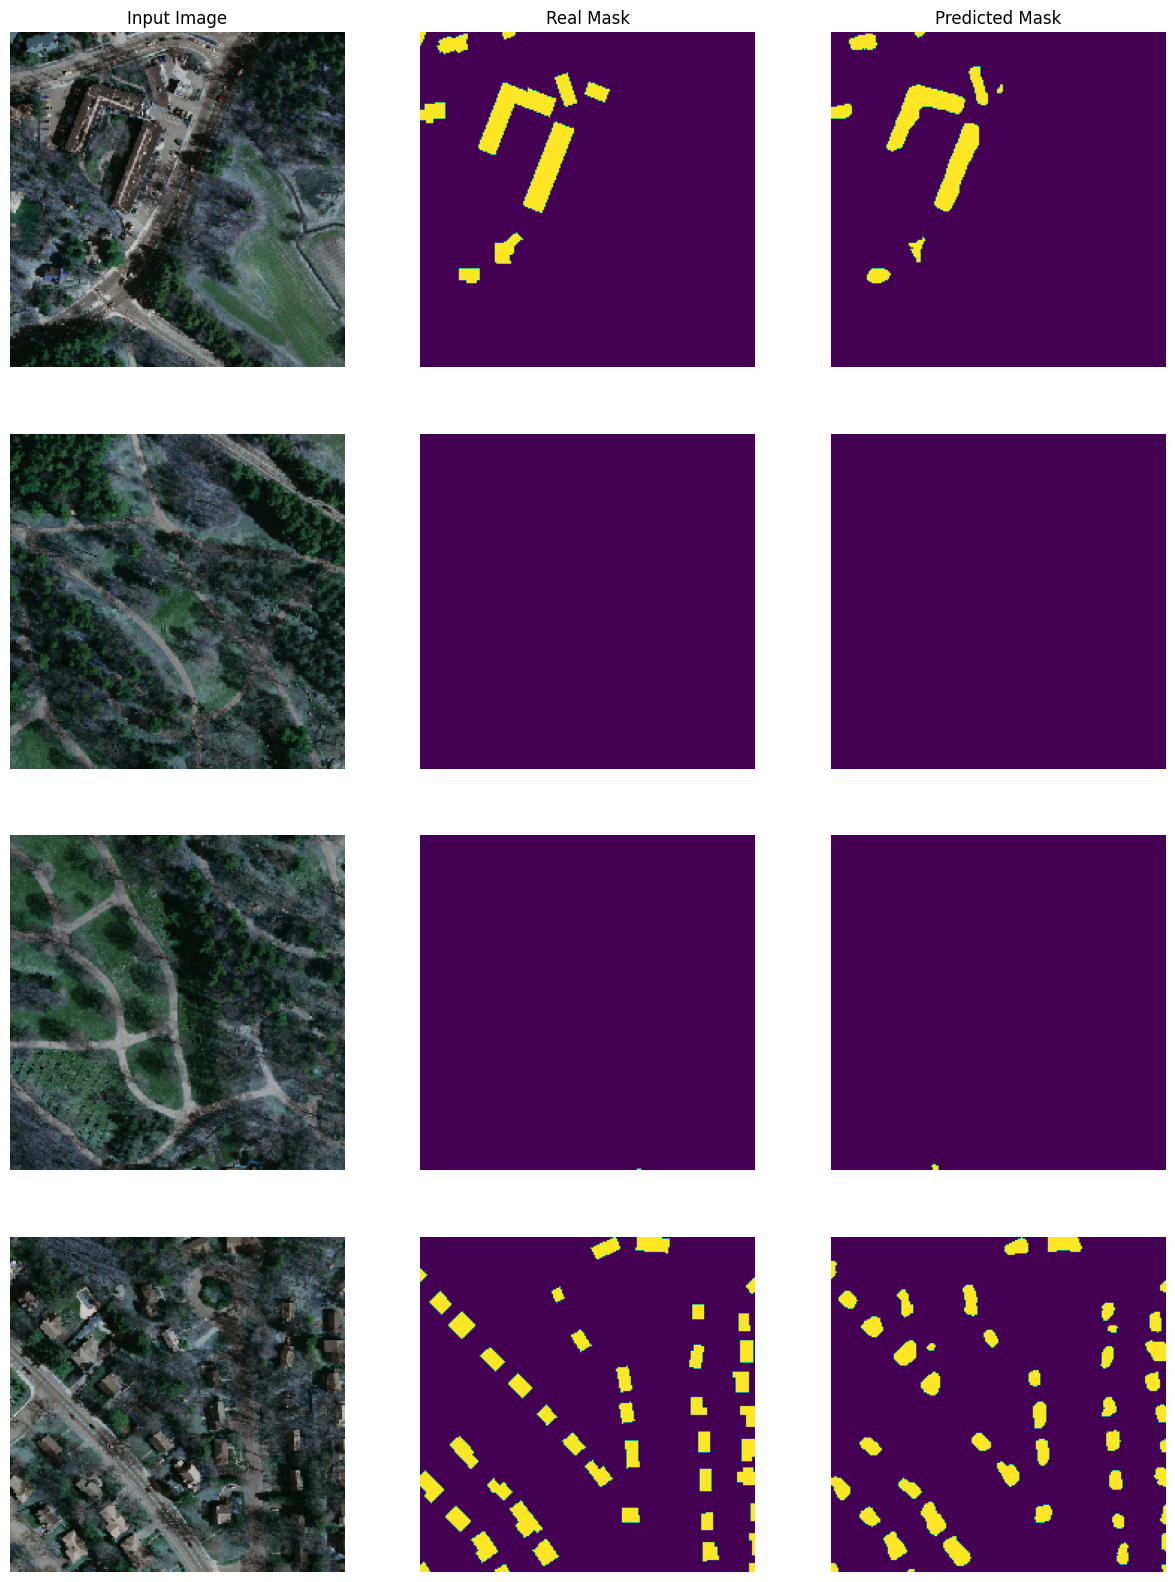

In [14]:
def plot_images_comparation(list_images_rows,titles_rows=["Input Image", "Real Mask", "Predicted Mask"]):
    num_rows = len(list_images_rows)
    fig=plt.figure(figsize=(15, 5*num_rows))
    index=1
    for i in range(num_rows):
        for j in range(3):
            plt.subplot(num_rows,3,index)
            plt.imshow(list_images_rows[i][j])
            plt.axis('off')
            if i==0:
                plt.title(titles_rows[j])
            index+=1
    plt.show()

# Índices de las imágenes que deseas mostrar agrupadas
max_image=4
# Preparar imágenes y títulos para visualizar en grupos de tres
images_list = []
preds=unet_model.predict(X_val_pro[:4])
pred_binary = (preds > 0.5).astype(np.uint8)
# Agrupar imágenes y títulos en filas de tres
for i in range(0, 4):
    input_image = X_val_pro[i]
    ground_truth_mask = Y_val_pro[i]
    predicted_mask = pred_binary[i]
    images_list.append([input_image, ground_truth_mask, predicted_mask])
plot_images_comparation(images_list)


# --------------------